In [1]:
import random

In [2]:
from data_process import get_clean_df

In [3]:
clean_df = get_clean_df()

selecting data from db...
data selected
Data Fixing... Search error date
Error type - small: 866
Error type - toomuch: 5
Data Fixing... Done
Validation... Search error date
Error type - small: 0
Error type - toomuch: 0
Done, 478.21 seconds


In [4]:
import pandas as pd
import time

In [5]:
market_cap_df = pd.read_pickle('market_cap.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/monthly_factor.pkl'

## 중복 날짜 탐색

In [ ]:
def get_duplicated_dict(df):
    duplicated_indices = df.groupby('Code').apply(find_duplicates)
    return {code: indices for code, indices in duplicated_indices.items() if indices}

def find_duplicates(group):
    duplicates = group[group.duplicated('yyyymm', keep=False)]
    return duplicates.index.tolist()

In [ ]:
duplicated_dict = get_duplicated_dict(market_cap_df)

## drop 할 인덱스 추리기

In [ ]:
valid_drop_dict = dict()
for code, indices in duplicated_dict.items():
    valid_drop_dict[code] = {"valid":"", "drop":[]}
    for idx in indices:
        if not valid_drop_dict[code]['valid'] and market_cap_df.iloc[idx]['시가총액']:
            valid_drop_dict[code]['valid'] = idx
        else:
            valid_drop_dict[code]['drop'].append(idx)

In [ ]:
drop_indices = []
for _, values in valid_drop_dict.items():
    drop_indices.extend(values['drop'])

## drop

In [ ]:
cleaned_market_cap_df = market_cap_df.drop(drop_indices, axis=0)

## 중복되는 date이 더이상 없는지 확인하자

In [ ]:
check_dup = get_duplicated_dict(cleaned_market_cap_df)

In [ ]:
check_dup

## 피봇

In [ ]:
pivot_market_cap_df = cleaned_market_cap_df.pivot(index='yyyymm', columns='Code', values='시가총액')
pivot_market_cap_df = pivot_market_cap_df.fillna(0)

In [ ]:
pivot_market_cap_df[:2]

## 종목 코드 일치시키기

In [ ]:
market_cap_columns = set([c[1:] for c in pivot_market_cap_df.columns])

In [ ]:
price_columns = set(list(clean_df.columns))
len(set(price_columns))

In [ ]:
market_cap_drop = market_cap_columns - price_columns
columns_to_drop = ['A' + c for c in market_cap_drop]
clean_market_cap_df = pivot_market_cap_df.drop(columns_to_drop, axis=1)

In [ ]:
price_df_drop = price_columns - market_cap_columns
clean_price_df = clean_df.drop(price_df_drop, axis=1)

In [ ]:
print(len(clean_market_cap_df.columns), len(clean_price_df.columns))

In [ ]:
clean_market_cap_df.columns = [col[1:] for col in clean_market_cap_df.columns]

## 백테스팅
- 10분위 시총 값을 얻고 (이것보다 시총이 작으면 해당 날짜에 10분위에 해당함)
- 가격 데이터의 기간을 시총 데이터와 일치시키고
- 가격 데이터의 값을 10분위 인지 아닌지 나타내는 boolean 데이터프레임 생성
- 백테스팅

In [21]:
clean_market_cap_df.index = pd.to_datetime(clean_market_cap_df.index + '01')

In [22]:
clean_market_cap_df[:2]

,000020,000040,000050,000070,000080,000100,000120,000140,000150,000180,...,388790,389030,389140,389260,391710,396300,399720,402340,408920,412350
yyyymm,,,,,,,,,,,,,,,,,,,,,
2002-02-01,5.362842e+10,3.900840e+09,4.520016e+10,2.259622e+11,4.521943e+10,4.209331e+11,9.459100e+10,1.147421e+12,4.786816e+11,1.053000e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-03-01,5.642157e+10,3.308171e+09,4.113454e+10,2.836175e+11,4.534937e+10,4.001995e+11,1.019057e+11,1.438829e+12,4.891790e+11,1.014000e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 17년 10월 결측치를 9월 값으로 취함

In [23]:
if pd.Timestamp('2017-10-01') not in clean_market_cap_df.index:
    clean_market_cap_df.loc[pd.Timestamp('2017-10-01')] = clean_market_cap_df.loc[pd.Timestamp('2017-09-01')]
    clean_market_cap_df.sort_index(inplace=True)

### 날짜별 10분위 시총 값을 얻는다

In [24]:
real_10th_quantile_values_non_zero = clean_market_cap_df.apply(lambda x: x[x > 0].sort_values(ascending=False).iloc[max(int(len(x[x > 0]) * 0.9) - 1, 0)], axis=1)
print(real_10th_quantile_values_non_zero[-10:] / 100000000)

yyyymm
2021-09-01    649.812034
2021-10-01    596.819784
2021-11-01    610.108444
2021-12-01    547.393400
2022-01-01    608.524224
2022-02-01    574.120000
2022-03-01    564.901691
2022-04-01    612.148009
2022-05-01    609.648455
2022-06-01    590.578290
dtype: float64


In [25]:
start_date = clean_market_cap_df.iloc[0].name
end_date = clean_market_cap_df.iloc[-1].name

print(start_date)
print(end_date)

2002-02-01 00:00:00
2022-06-01 00:00:00


### 가격 데이터의 기간을 시총 데이터 기간과 일치하게

In [26]:
filtered_price_df = clean_price_df[(clean_price_df.index >= start_date) & (clean_price_df.index < end_date+pd.DateOffset(months=1))]
filtered_price_df

종목코드,000020,000040,000050,000070,000080,000100,000120,000140,000150,000180,...,388790,389030,389140,389260,391710,396300,399720,402340,408920,412350
날짜,,,,,,,,,,,,,,,,,,,,,
2002-02-01,1920.0,24917.0,2044.0,19825.0,0.0,5890.0,8775.0,33671.0,18328.0,1725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-04,1900.0,25192.0,1900.0,20336.0,0.0,5843.0,9075.0,32389.0,16922.0,1799.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-05,1962.0,23609.0,1774.0,21307.0,0.0,5843.0,8250.0,32389.0,16881.0,1740.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-06,1980.0,23471.0,1799.0,21818.0,0.0,5946.0,9075.0,35275.0,17042.0,1725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-07,1882.0,24091.0,1730.0,22482.0,0.0,5935.0,8325.0,40566.0,16721.0,1671.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,9350.0,617.0,12400.0,74100.0,31600.0,50995.0,112500.0,11400.0,63600.0,1885.0,...,2140.0,4037.0,16600.0,16650.0,2570.0,7310.0,26700.0,40950.0,2307.0,17350.0
2022-06-27,9670.0,629.0,12300.0,74400.0,31700.0,50628.0,115500.0,11700.0,68200.0,1990.0,...,2140.0,4053.0,17350.0,17000.0,2575.0,7880.0,28100.0,41950.0,2307.0,17400.0
2022-06-28,9820.0,630.0,12400.0,74900.0,32000.0,51360.0,114500.0,11650.0,70400.0,2010.0,...,2140.0,4354.0,18050.0,17250.0,2605.0,8000.0,29400.0,41400.0,2307.0,17650.0


In [29]:
def is_in_bottom_10_percent(row):
    date = row.name
    month_start = pd.Timestamp(year=date.year, month=date.month, day=1)

    bottom_10_quantile = real_10th_quantile_values_non_zero.loc[month_start]
    market_cap = clean_market_cap_df.loc[month_start]

    is_above_zero = market_cap > 0
    is_below_bottom_10 = market_cap < bottom_10_quantile
    
    return is_above_zero & is_below_bottom_10

is_bottom_10 = filtered_price_df.apply(is_in_bottom_10_percent, axis=1)

## 10분위에 해당하는 종목 갯수는 몇개인가? (100~300개인데, 전체 종목수랑 비교해서도 봐야 할듯)

In [32]:
daily_true_counts = is_bottom_10.sum(axis=1)

In [33]:
daily_true_counts

날짜
2002-02-01     87
2002-02-04     87
2002-02-05     87
2002-02-06     87
2002-02-07     87
             ... 
2022-06-24    225
2022-06-27    225
2022-06-28    225
2022-06-29    225
2022-06-30    225
Length: 5045, dtype: int64

In [34]:
true_code = []
false_code = []

for i, value in is_bottom_10.iloc[0].items():    
    if value:
        true_code.append(i)
    else:
        false_code.append(i)

In [35]:
clean_market_cap_df[random.choice(true_code)]

yyyymm
2002-02-01    8.988351e+09
2002-03-01    4.742130e+09
2002-04-01    7.665619e+10
2002-05-01    5.979946e+10
2002-06-01    4.957863e+10
                  ...     
2022-02-01    1.665896e+11
2022-03-01    1.673609e+11
2022-04-01    1.739165e+11
2022-05-01    1.904983e+11
2022-06-01    1.847139e+11
Name: 008700, Length: 245, dtype: float64

In [36]:
len(true_code)

87

In [37]:
len(false_code)

2161

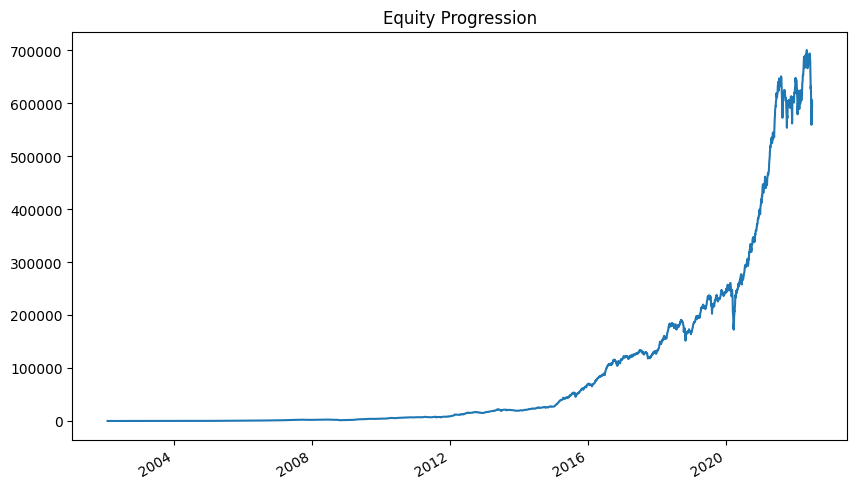

In [39]:
import bt

s = bt.Strategy('10th_small', [bt.algos.SelectWhere(is_bottom_10),
                               bt.algos.WeighEqually(),
                               bt.algos.RunMonthly(),
                               bt.algos.Rebalance()])

backtest = bt.Backtest(s, filtered_price_df)
result = bt.run(backtest)

import matplotlib.pyplot as plt
%matplotlib inline

result.plot(figsize=(10, 6), legend=False)
plt.show()

In [40]:
result.get_security_weights().head()

,000040,000300,001140,001250,001770,001840,002140,002290,002360,002450,...,164060,169330,361670,114630,408920,246960,147760,217480,305090,308100
2002-01-31,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-01,0.0,0.010950,0.011040,0.0,0.007280,0.011214,0.010926,0.011050,0.011466,0.010448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-04,0.0,0.011011,0.011001,0.0,0.007195,0.011213,0.010589,0.011095,0.013220,0.012083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-05,0.0,0.010853,0.010943,0.0,0.007264,0.011278,0.010395,0.010746,0.013210,0.011974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-06,0.0,0.010558,0.011324,0.0,0.007341,0.011291,0.010640,0.010837,0.013601,0.010248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


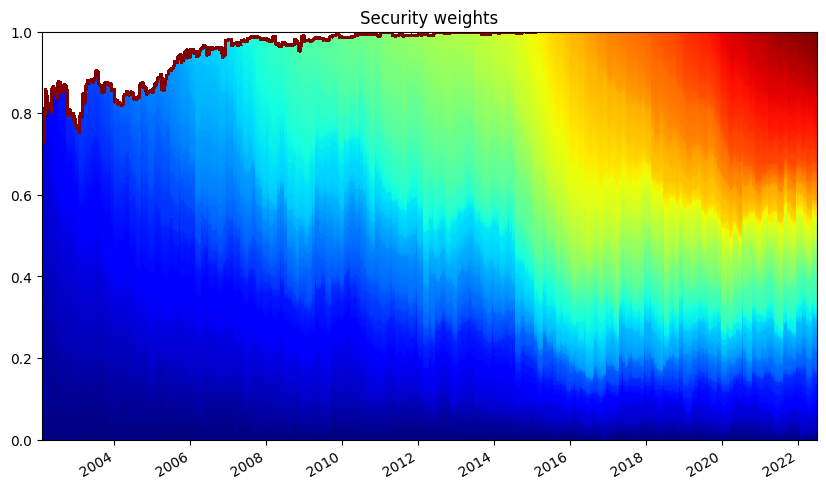

In [43]:
from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                             ylim=[0, 1],
                                             legend=False,
                                             colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
# plt.legend(reversed(handles),
#            reversed(labels),
#            loc='lower right',
#            bbox_to_anchor=(1.15, 0))
plt.title("Security weights")
plt.show()

In [42]:
result.display()

Stat                 10th_small
-------------------  ------------
Start                2002-01-31
End                  2022-06-30
Risk-free rate       0.00%

Total Return         593916.77%
Daily Sharpe         2.00
Daily Sortino        3.91
CAGR                 53.07%
Max Drawdown         -49.65%
Calmar Ratio         1.07

MTD                  -13.73%
3m                   -9.62%
6m                   -5.34%
YTD                  -5.34%
1Y                   -4.88%
3Y (ann.)            36.43%
5Y (ann.)            34.76%
10Y (ann.)           44.18%
Since Incep. (ann.)  53.07%

Daily Sharpe         2.00
Daily Sortino        3.91
Daily Mean (ann.)    45.75%
Daily Vol (ann.)     22.83%
Daily Skew           17.73
Daily Kurt           832.05
Best Day             65.20%
Worst Day            -9.42%

Monthly Sharpe       1.73
Monthly Sortino      4.39
Monthly Mean (ann.)  46.64%
Monthly Vol (ann.)   26.94%
Monthly Skew         1.71
Monthly Kurt         15.63
Best Month           64.50%
Worst Month

- 시간은 일치시켰는데, 시총 데이터에 있는 종목이 가격 데이터에는 없는 경우가 있다. A를 떼버리고, 가격 데이터에 없는 column은 is_bottom에서 빼버리자
- 시총 하위 10분위인지 True False 데이터 만들기 (완료)
- 하위 10분위 종목만 매수하는 백테스팅 수행하기 (완료)
- 종목 뽑기 (완료)
- 정리하자
- validation들은 모두 나중으로 미루자

## 매수 종목, 비중 확인...

In [49]:
asset_position = result.get_security_weights()

Timestamp('2004-02-17 00:00:00')

In [62]:
t = asset_position.index[5000]
print(t)

2022-04-25 00:00:00


In [63]:
for code, ratio in asset_position.loc[t][asset_position.loc[t] != 0].items():
    print(code, ratio)

001770 0.004166924471828564
004920 0.004297646399794163
005030 0.0042800013761116595
008290 0.004207146738392603
013000 0.004246965999074349
014910 0.004089389676240046
018500 0.004575757427571639
018680 0.004002239727255345
020400 0.005331060589794293
023790 0.0037693579999660077
025880 0.008399244611736028
026910 0.004194274222005817
032750 0.003959236749327982
038010 0.00385067006243534
005110 0.004017233942485823
002420 0.00401266819854161
001420 0.004173223813230185
025870 0.0055714467308243636
027040 0.004900860431674131
033790 0.004354460000621845
054410 0.0043407094340730925
043200 0.004424264477069329
045300 0.004392922659921716
053060 0.003923700631656311
060260 0.0042990572126272095
039980 0.004284171712544094
065420 0.0043544186479515445
065500 0.004206808610904704
032800 0.004348566879797735
033250 0.005351842863764265
044780 0.004632083563706308
058450 0.004354450794903721
053160 0.00407880821468592
050760 0.004508150487550482
001000 0.0044894840675238044
025890 0.0039980

In [53]:
for code, ratio in asset_position.iloc[-1][asset_position.iloc[-1] != 0].items():
    print(code, ratio)

001770 0.004266293681821981
002290 0.003919980227723257
004920 0.005655669435705261
008290 0.003917313636348291
010640 0.005022585459096726
012620 0.004186750473193752
013000 0.004128888470574475
014910 0.003643533487793607
018500 0.004467829405564914
018680 0.003907219476914308
020400 0.004234883794275198
021040 0.004376923554800027
023790 0.004769006760352386
024940 0.004533717949230086
026910 0.004789282282145368
032750 0.004500345995870473
051630 0.005428836614782741
002420 0.004489206579754219
006920 0.0038291208402929343
001420 0.0044134915458650505
025870 0.0042635917379098475
030720 0.0036907476429086828
027040 0.004399124274759934
033790 0.005170915951092496
035200 0.003754941116589352
054410 0.004320063207400512
043200 0.004315610471171483
045300 0.0038760908945561345
053060 0.004445844167736316
060260 0.0042534859626422224
036180 0.004835275933001068
039980 0.004202188757829647
043710 0.0037804023505486487
065420 0.004420541683503446
032800 0.004340122910371354
033250 0.0040